## RNA Velocity using scVelo
Marissa Esteban

Data: CITEseq YS006_UW

I did pre processing in Suerat and saved object as .h5Seurat to perform RNAvelo in Python wtih scVelo

In [1]:
# Setup
import scanpy as sc
import scvelo as scv
import anndata
import loompy
import mygene
import scipy

In [4]:

h5ad_path = "/Volumes/PortableSSD/IntegratedMultimodal_CITEseq.h5ad"
adata = sc.read_h5ad(h5ad_path)
adata.obs.index = [x.split('-')[0] for x in adata.obs.index]    # TTTGGAGTCGGTTGTA-1_1

loom_paths = ["/Volumes/PortableSSD/YS001/possorted_genome_bam_KLWV0.loom",
              "/Volumes/PortableSSD/YS002/possorted_genome_bam_PNEM4.loom",
              "/Volumes/PortableSSD/YS003/possorted_genome_bam_8Q2XV.loom",
              "/Volumes/PortableSSD/YS004/possorted_genome_bam_0XB2N.loom",
              "/Volumes/PortableSSD/YS005/possorted_genome_bam_HX08G.loom",
              "/Volumes/PortableSSD/YS006/possorted_genome_bam_751VB.loom"]
combined_loom_path = "/Volumes/PortableSSD/citeseq_combined.loom"

loompy.combine(loom_paths, combined_loom_path)
ldata = sc.read_loom(combined_loom_path)
ldata.obs.index = [x.split(':')[1] for x in ldata.obs.index]    # possorted_genome_bam_751VB:AAAGTCCGTAAGGTCGx
ldata.obs.index = [x[:-1] for x in ldata.obs.index] 

BlockingIOError: [Errno 35] Unable to synchronously open file (unable to lock file, errno = 35, error message = 'Resource temporarily unavailable')

### SANITY CHECKING

- inspecting andata and ldata objects (cell and gene counts)
- checking for duplicates

In [5]:
print("=== Seurat-derived AnnData (adata) ===")
print("Cells (obs):", adata.n_obs)
print("Genes (var):", adata.n_vars)
print("\nFirst 10 cell names:", adata.obs.index[:10].tolist())
print("\nFirst 10 gene names:", adata.var.index[:10].tolist())

print("\n\n=== Loom RNA velocity AnnData (ldata) ===")
print("Cells (obs):", ldata.n_obs)
print("Genes (var):", ldata.n_vars)
print("\nFirst 10 cell names:", ldata.obs.index[:10].tolist())
print("\nFirst 10 gene names:", ldata.var.index[:10].tolist())

print("\n\n=== Layer shapes in ldata ===")
for layer in ["spliced", "unspliced", "ambiguous"]:
    if layer in ldata.layers:
        print(f"{layer}: {ldata.layers[layer].shape}")



# check for duplicates in adata and ladata
print("\n\n=== Checking for dupicates ===")
print("Total cells in adata:", len(adata.obs.index))
print("Unique cells in adata:", len(adata.obs.index.unique()))
print("Duplicate barcodes in adata:", len(adata.obs.index) - len(adata.obs.index.unique()))

print("\nTotal cells in ldata:", len(ldata.obs.index))
print("Unique cells in ldata:", len(ldata.obs.index.unique()))
print("Duplicate barcodes in ldata:", len(ldata.obs.index) - len(ldata.obs.index.unique()))

# Show some duplicates if they exist
from collections import Counter
adata_counts = Counter(adata.obs.index)
adata_duplicates = {bc: count for bc, count in adata_counts.items() if count > 1}
print(f"\nNumber of duplicated barcodes: {len(adata_duplicates)}")
if adata_duplicates:
    print("Examples:", list(adata_duplicates.items())[:5])


=== Seurat-derived AnnData (adata) ===
Cells (obs): 11109
Genes (var): 30481

First 10 cell names: ['AAACCCAAGAACAGGA', 'AAACCCAAGTCTCTGA', 'AAACGAAAGACTACGG', 'AAACGAAAGATTCGCT', 'AAACGAAAGCTCACTA', 'AAACGAACAGCTGTAT', 'AAACGAACATCCTTGC', 'AAACGAAGTACTGACT', 'AAACGAAGTGTATCCA', 'AAACGAAGTTGCTCGG']

First 10 gene names: ['Xkr4', 'Gm19938', 'Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h', 'Npbwr1', '4732440D04Rik']


=== Loom RNA velocity AnnData (ldata) ===
Cells (obs): 13821
Genes (var): 33696

First 10 cell names: ['AAAGGGCAGTCATACC', 'AAAGGTATCGGAAGGT', 'AAATGGACACTCAAGT', 'AAAGAACCAGTTGTTG', 'AAACGAACATCCTTGC', 'AAAGGATTCCAATCTT', 'AAATGGAAGTGGAAAG', 'AAAGTCCAGAACGCGT', 'AAAGTGAGTCACGTGC', 'AAAGGGCGTTGTCTAG']

First 10 gene names: [np.str_('ENSMUSG00000079800'), np.str_('ENSMUSG00000095092'), np.str_('ENSMUSG00000079794'), np.str_('ENSMUSG00000079192'), np.str_('ENSMUSG00000094799'), np.str_('ENSMUSG00000095250'), np.str_('ENSMUSG00000095787'), np.str_('ENSMUSG00000095672'

In [6]:
# Remove duplicates from both datasets (keep first occurrence)
print("\n=== Removing duplicates ===")
adata = adata[~adata.obs.index.duplicated(keep='first'), :]
ldata = ldata[~ldata.obs.index.duplicated(keep='first'), :]

print(f"adata after dedup: {adata.shape}")
print(f"ldata after dedup: {ldata.shape}")

# Find common barcodes
common_barcodes = set(adata.obs.index).intersection(set(ldata.obs.index))
print(f"\n=== Common cells ===")
print(f"Cells in common: {len(common_barcodes)}")

# Subset both datasets to only common cells
# Convert to list and sort for reproducibility
common_barcodes = sorted(list(common_barcodes))

adata = adata[common_barcodes, :]
ldata = ldata[common_barcodes, :]

print(f"\n=== Final datasets ===")
print(f"Final adata shape: {adata.shape}")
print(f"Final ldata shape: {ldata.shape}")
print(f"Indices match: {all(adata.obs.index == ldata.obs.index)}")


=== Removing duplicates ===
adata after dedup: (11104, 30481)
ldata after dedup: (13813, 33696)

=== Common cells ===
Cells in common: 10989

=== Final datasets ===
Final adata shape: (10989, 30481)
Final ldata shape: (10989, 33696)
Indices match: True


In [7]:
# converting the loom's ENSEMBL ID's to match 

mg = mygene.MyGeneInfo()
gene_index = ldata.var.index.to_series()

# only grab the genes that have ENSEMBL IDs
is_ensembl = gene_index.str.startswith("ENSMUSG")

print("Total genes:", gene_index.shape[0])
print("ENSEMBL-like genes:", is_ensembl.sum())
print("Already-symbol-like genes:", (~is_ensembl).sum(), '\n')

# only query the ENSMUSG IDs
ens_ids = gene_index[is_ensembl].unique().tolist()

results = mg.querymany(
    ens_ids,
    scopes="ensemblgene",   # or "ensembl.gene" depending on mygene version, but this usually works
    fields="symbol",
    species="mouse",
    as_dataframe=False
)

# Build mapping dict ENSMUSG -> symbol
ens_to_symbol = {r["query"]: r.get("symbol", None) for r in results}

# QC on mapping
total_ens = len(ens_ids)
mapped_ens = sum(v is not None for v in ens_to_symbol.values())
print("Total ENSMUSG IDs:", total_ens)
print("Mapped ENSMUSG → symbol:", mapped_ens)
print("Unmapped ENSMUSG:", total_ens - mapped_ens)

# 4) Create a 'symbol' column:
# default: keep existing name
ldata.var["symbol"] = gene_index.copy()

# replace ENSMUSG entries with their symbol
for g in gene_index[is_ensembl]:
    sym = ens_to_symbol.get(g, None)
    if sym is not None:
        ldata.var.at[g, "symbol"] = sym


ldata.var.index = ldata.var["symbol"]

gene_index = ldata.var.index.to_series()
is_ensembl = gene_index.str.startswith("ENSMUSG")

print("Total ENSMUSG IDs after mapping: ", is_ensembl.sum())

INFO:biothings.client:querying 1-248 ...


Total genes: 33696
ENSEMBL-like genes: 248
Already-symbol-like genes: 33448 



INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Total ENSMUSG IDs: 248
Mapped ENSMUSG → symbol: 203
Unmapped ENSMUSG: 45
Total ENSMUSG IDs after mapping:  45


In [9]:
# Intersect with Seurat genes
ldata.var_names_make_unique()  # This handles any duplicate gene symbol

print("Total number of var names: ", len(adata.var_names))

# Now find common genes between the two datasets
common_genes = adata.var.index.intersection(ldata.var.index)
print("Overlapping genes after symbol mapping:", len(common_genes))

# Subset both datasets to common genes
adata_subset = adata[:, common_genes].copy()
ldata_subset = ldata[:, common_genes].copy()

print(f"adata shape: {adata_subset.shape}")
print(f"ldata shape: {ldata_subset.shape}")

Total number of var names:  30481
Overlapping genes after symbol mapping: 29365
adata shape: (10989, 29365)
ldata shape: (10989, 29365)


In [10]:
# Sanity Checks

# Verify cell barcodes match
print("Cells match:", (adata_subset.obs.index == ldata_subset.obs.index).all())

# If they don't match, reorder ldata_subset to match adata_subset:
ldata_subset = ldata_subset[adata_subset.obs.index, :].copy()

# Double-check genes are in same order
print("Genes match:", (adata_subset.var.index == ldata_subset.var.index).all())

Cells match: True
Genes match: True


### Integrating Loom and OWHA object

In [11]:
# Add velocity layers to adata_subset
adata_subset.layers["spliced"] = ldata_subset.layers["spliced"].copy()
adata_subset.layers["unspliced"] = ldata_subset.layers["unspliced"].copy()
adata_subset.layers["ambiguous"] = ldata_subset.layers["ambiguous"].copy()

# Verify they were added
print("Layers in adata_subset:", list(adata_subset.layers.keys()))
print("Spliced shape:", adata_subset.layers["spliced"].shape)
print("Unspliced shape:", adata_subset.layers["unspliced"].shape)

Layers in adata_subset: ['spliced', 'unspliced', 'ambiguous']
Spliced shape: (10989, 29365)
Unspliced shape: (10989, 29365)


In [12]:
adata_subset.obs

orig.ident  nCount_RNA  nFeature_RNA  nCount_ADT  \
AAACCCAAGAACAGGA  UW_CITEseq_1      4246.0          1723       399.0   
AAACCCAAGGTACCTT  UW_CITEseq_2      1618.0           887      1003.0   
AAACCCAAGTCTCTGA  UW_CITEseq_1     20671.0          4136       226.0   
AAACGAAAGACTACGG  UW_CITEseq_1      5337.0          2193       303.0   
AAACGAAAGATTCGCT  UW_CITEseq_1     10292.0          2465       227.0   
...                        ...         ...           ...         ...   
TTTGTTGCAGTTCACA  UW_CITEseq_1      5196.0          1820       319.0   
TTTGTTGGTACAATAG  UW_CITEseq_1     28140.0          4994       217.0   
TTTGTTGGTCTCCTGT  UW_CITEseq_1     11725.0          2928       204.0   
TTTGTTGGTTGCATAC  UW_CITEseq_1     17075.0          3918       235.0   
TTTGTTGTCAAATAGG  UW_CITEseq_1     15494.0          3833       178.0   

                  nFeature_ADT  percent_mito  percent_ribo  nCount_SCT  \
AAACCCAAGAACAGGA            78      8.431465      6.947715      8358.0   
AAACCCAAGGTACCTT            95      2.472188      9.085290      2988.0   
AAACCCAAGTCTCTGA            60      3.420251     40.501185      9804.0   
AAACGAAAGACTACGG            75      0.093686     16.170133      8467.0   
AAACGAAAGATTCGCT            70      4.537505     39.360668      9703.0   
...                        ...           ...           ...         ...   
TTTGTTGCAGTTCACA            67      4.849885     19.861432      8922.0   
TTTGTTGGTACAATAG            62      5.582800     23.528785      9408.0   
TTTGTTGGTCTCCTGT            65      1.628998     30.857143      9928.0   
TTTGTTGGTTGCATAC            70      4.527086     25.956076     10222.0   
TTTGTTGTCAAATAGG            60      4.298438     31.541242     10164.0   

                  nFeature_SCT pca_clusters  ...    gptcelltype  \
AAACCCAAGAACAGGA          1793           57  ...    Fibroblasts   
AAACCCAAGGTACCTT           894           46  ...  Keratinocytes   
AAACCCAAGTCTCTGA          3093           20  ...  Keratinocytes   
AAACGAAAGACTACGG          2192           24  ...    Fibroblasts   
AAACGAAAGATTCGCT          2457           35  ...  Keratinocytes   
...                        ...          ...  ...            ...   
TTTGTTGCAGTTCACA          1823           42  ...        T cells   
TTTGTTGGTACAATAG          2784           20  ...  Keratinocytes   
TTTGTTGGTCTCCTGT          2922           35  ...  Keratinocytes   
TTTGTTGGTTGCATAC          3655           35  ...  Keratinocytes   
TTTGTTGTCAAATAGG          3746           20  ...  Keratinocytes   

                             sctype_skinDB         singleR           celltype  \
AAACCCAAGAACAGGA             Cycling cells  Cardiomyocytes          Pericytes   
AAACCCAAGGTACCTT       Basal Keratinocytes    Erythrocytes  IFE Keratinocytes   
AAACCCAAGTCTCTGA             Cycling cells    Erythrocytes  IFE Keratinocytes   
AAACGAAAGACTACGG               Fibroblasts     Fibroblasts        Fibroblasts   
AAACGAAAGATTCGCT  Suprabasal Keratinocytes         T cells  IFE Keratinocytes   
...                                    ...             ...                ...   
TTTGTTGCAGTTCACA       Basal Keratinocytes         T cells  IFE Keratinocytes   
TTTGTTGGTACAATAG          OB Keratinocytes     Hepatocytes   HF Keratinocytes   
TTTGTTGGTCTCCTGT  Suprabasal Keratinocytes         T cells  IFE Keratinocytes   
TTTGTTGGTTGCATAC  Suprabasal Keratinocytes    Erythrocytes  IFE Keratinocytes   
TTTGTTGTCAAATAGG             Cycling cells         Neurons   HF Keratinocytes   

                    celltype_fine       metaclusters StressScore1  \
AAACCCAAGAACAGGA      Pericyte II          Pericytes     0.975801   
AAACCCAAGGTACCTT  Outer Bulge III   HF Keratinocytes     1.020054   
AAACCCAAGTCTCTGA          Basal I  IFE Keratinocytes     0.184575   
AAACGAAAGACTACGG     Reticular IV        Fibroblasts     0.938493   
AAACGAAAGATTCGCT        Spinous I  IFE Keratinocytes     0.546751   
...                           ...                ...          ...   
TTTGT

In [13]:
adata_subset.layers.keys()


KeysView(Layers with keys: spliced, unspliced, ambiguous)

## Starting RNA Velocity!

Now that we have combined the .loom file with our exported Seurat object (now AnnData object) we can explore with RNA Velocity

In [14]:
adata_subset.obsm.keys()


KeysView(AxisArrays with keys: X_cca, X_harmony, X_pca, X_rpca, X_umap.cca, X_umap.harmony, X_umap.pca, X_umap.rpca)

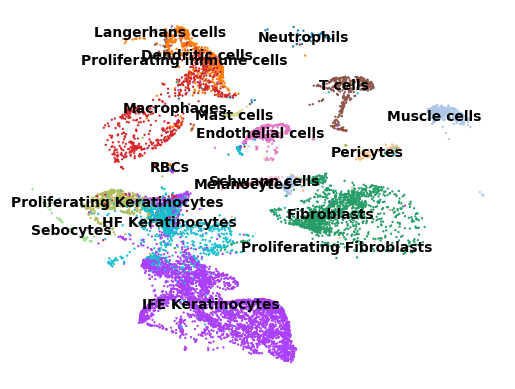

In [15]:
# plot umap to check
adata_subset.obsm["X_umap"] = adata_subset.obsm["X_umap.rpca"].copy()

sc.pl.umap(adata_subset, color="celltype", frameon=False,
           legend_loc='on data', title='', save='_celltypes_rpca.pdf')


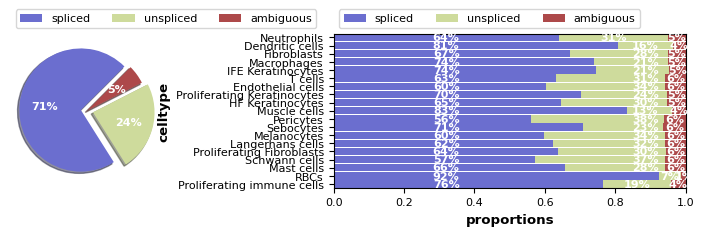

In [16]:
scv.pl.proportions(adata_subset, groupby='celltype')


In [17]:
adata_subset.obsm["X_pca"].shape


(10989, 50)

In [19]:
# pre-process
scv.pp.filter_and_normalize(adata_subset, min_shared_counts=20)
sc.pp.highly_variable_genes(adata_subset, n_top_genes=2000)

# subset to HVGs
adata_hvg = adata_subset[:, adata_subset.var['highly_variable']].copy()

# recompute neighbors on HVG PCA
scv.pp.moments(adata_hvg, n_pcs=30, n_neighbors=30)

Filtered out 209 genes that are detected 20 counts (shared).


/var/folders/t8/2h1r8md54q7b37k1630w747h0000gn/T/ipykernel_31518/1409331441.py:9: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata_hvg, n_pcs=30, n_neighbors=30)
/Users/marissaestaban/miniforge3/envs/scvelo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [20]:
# compute velocity ( this step will take a while )
try:
    scv.tl.recover_dynamics(adata_hvg, n_top_genes=500)
    scv.tl.velocity(adata_hvg, mode='dynamical')
    scv.tl.velocity_graph(adata_hvg)
except Exception as e:
    print("Error while fitting dynamics:", e)
    print("Current gene index:", adata_hvg.var_names[adata_hvg.var['fit_alpha'].isna()].tolist()[:10])

recovering dynamics (using 1/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:05:57) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


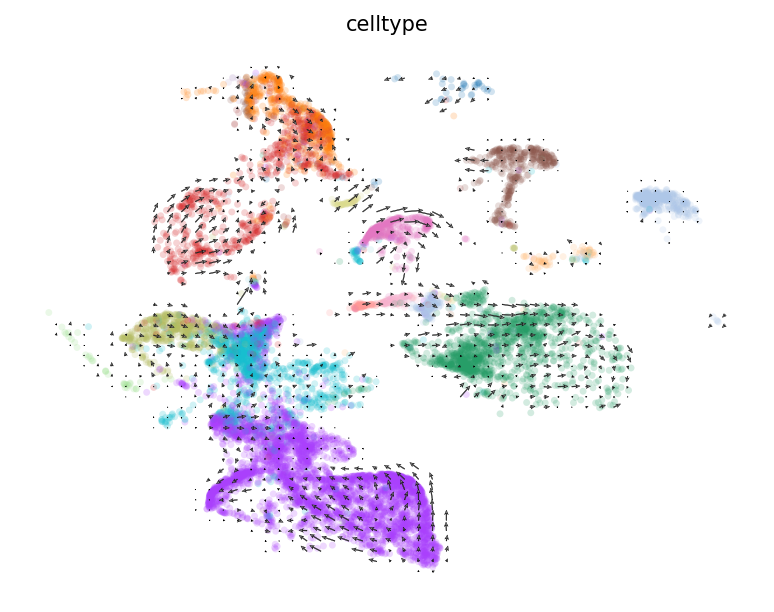

In [29]:
scv.pl.velocity_embedding_grid(
    adata_hvg,
    basis='X_umap',     
    color='celltype',
    dpi=150
)


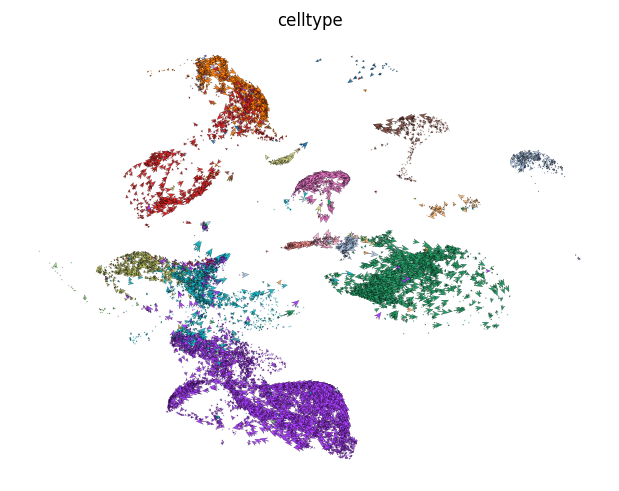

In [30]:
scv.pl.velocity_embedding(adata_hvg, 
                          arrow_length=3, 
                          arrow_size=2, 
                          color='celltype',
                          dpi=120)

In [31]:
scv.tl.rank_velocity_genes(adata_hvg, groupby='celltype')
df = scv.get_df(adata_hvg.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes


/Users/marissaestaban/miniforge3/envs/scvelo/lib/python3.10/site-packages/scvelo/tools/utils.py:463: DeprecationWarning: Please import `rankdata` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import rankdata


    finished (0:00:03) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


/var/folders/t8/2h1r8md54q7b37k1630w747h0000gn/T/ipykernel_31518/2477482753.py:2: DeprecationWarning: `get_df` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please `AnnData::get_df` or Scanpy's `scanpy.get.obs_df` or `scanpy.get.var_df`.
  df = scv.get_df(adata_hvg.uns['rank_velocity_genes']['names'])


Neutrophils Dendritic cells Fibroblasts Macrophages IFE Keratinocytes  \
0        Crem           Ptafr        Ugdh        Cd83             Gnai1   
1    Arhgap31            Cd83        Utrn        Cd36           Gm20186   
2     Tspan13            Crem        Tns1       Basp1             Tacc2   
3      Fndc3b          Trim25     Epb41l2        Crem               Fst   
4       Nr4a1           Basp1      Ifi207       Furin             Plet1   

   T cells Endothelial cells Proliferating Keratinocytes HF Keratinocytes  \
0   Samsn1             Mef2c                       Creb5            Fscn1   
1    Itpkb              Cd34                       Lamc1            Actn1   
2   Dnajb1             Cald1                        Nfib            Hspg2   
3  Pip4k2a              Srgn                    Slc39a10             Dag1   
4  Tspan13               Nxn                        Bcam            Mtss1   

  Muscle cells Pericytes Sebocytes Melanocytes Langerhans cells  \
0         H2aj     Epas1      Mgll       Ptprb             Cd83   
1        Lama2  Serping1     Fcgbp      Sptbn1             Crem   
2      Pcolce2    Ifi211     Ptafr      Zbtb20             Ccl4   
3         Sdc2    Zbtb20      Jam2        Flt1          Bcl2a1d   
4         Tnxb    Col5a2      Cd53      Rassf3          Bcl2a1b   

  Proliferating Fibroblasts Schwann cells Mast cells    RBCs  \
0                      Ptx3         Lama2       Crem    Jam2   
1                   Adamts2        Col5a2       Cd53  Rpl37a   
2                     Fabp4      Arhgap31   Arhgap31   Egfl7   
3                   Pcolce2        Tgfbr3    Alox5ap    Etv3   
4                     Fndc1          Rhoj       Pdpn  Laptm5   

  Proliferating immune cells  
0                      Ptafr  
1                       Cd83  
2                     Samsn1  
3                       Crem  
4                      Basp1

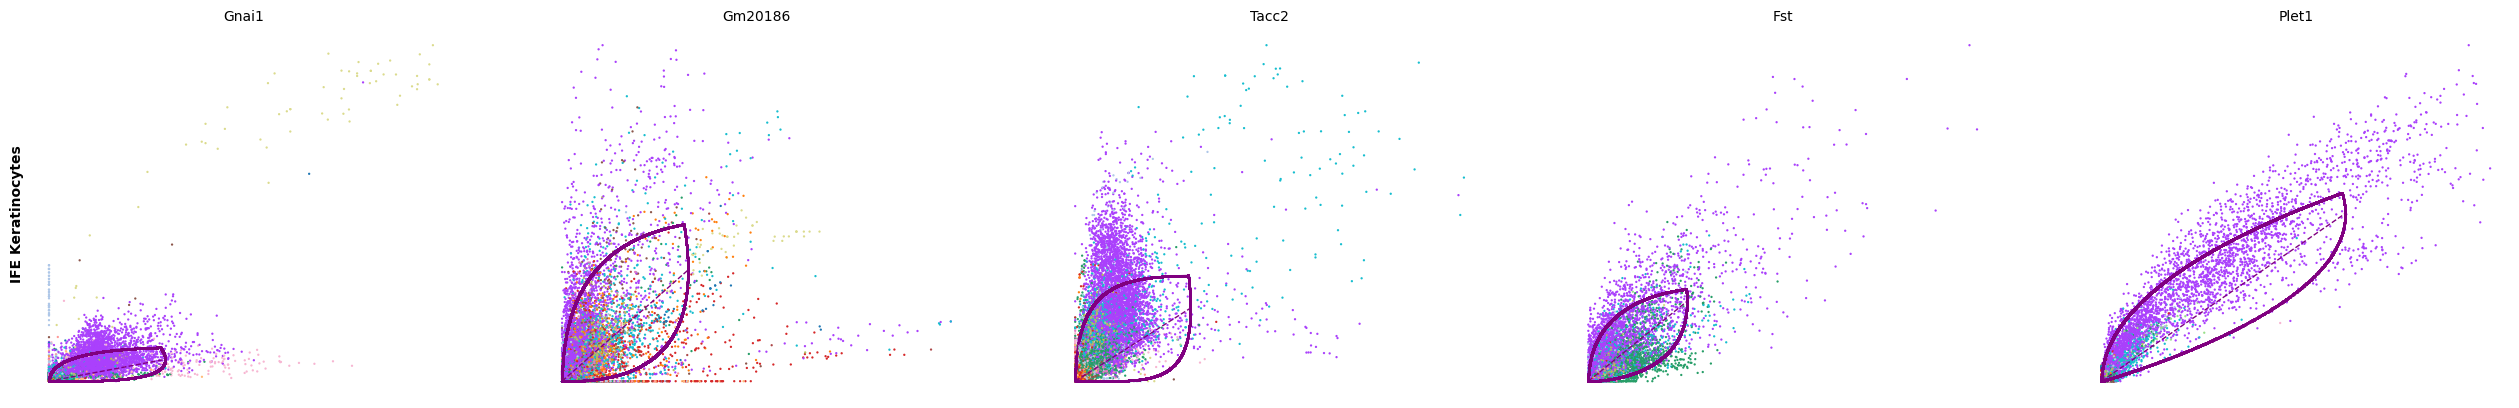

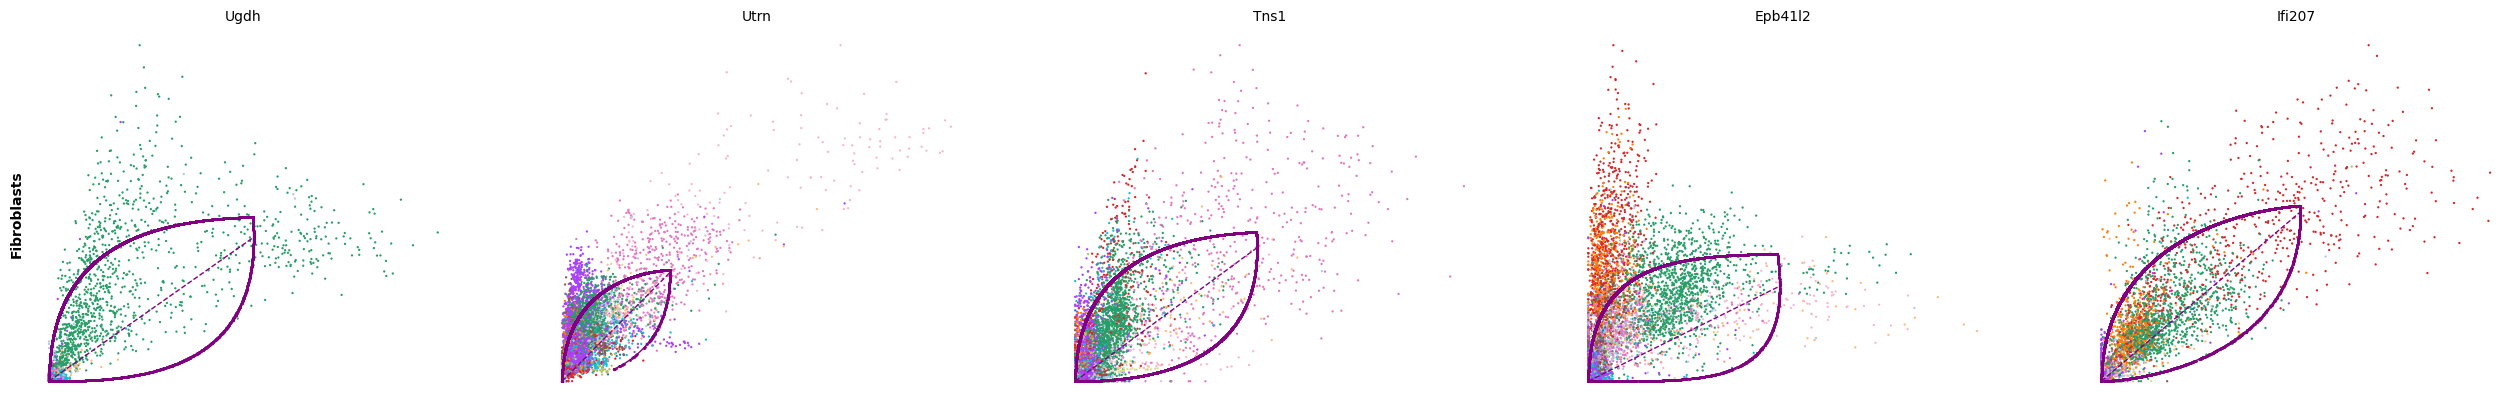

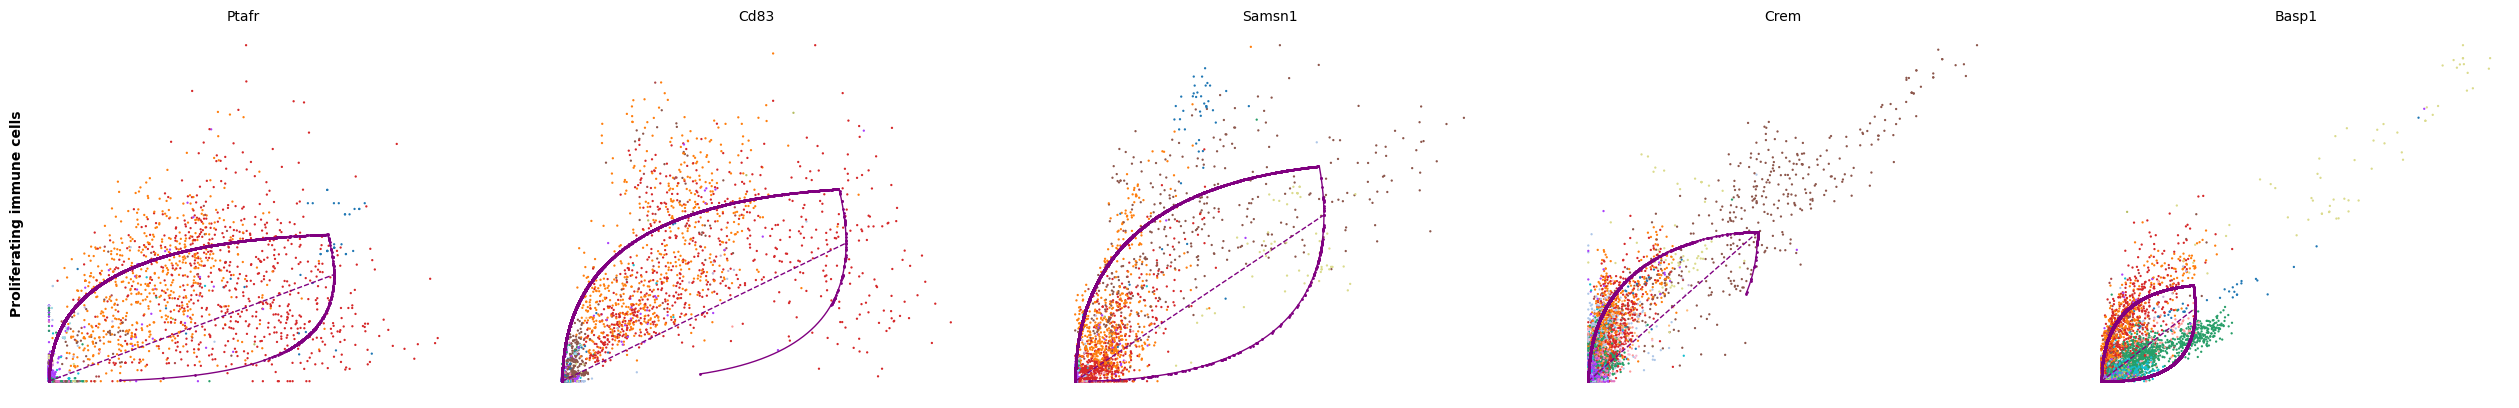

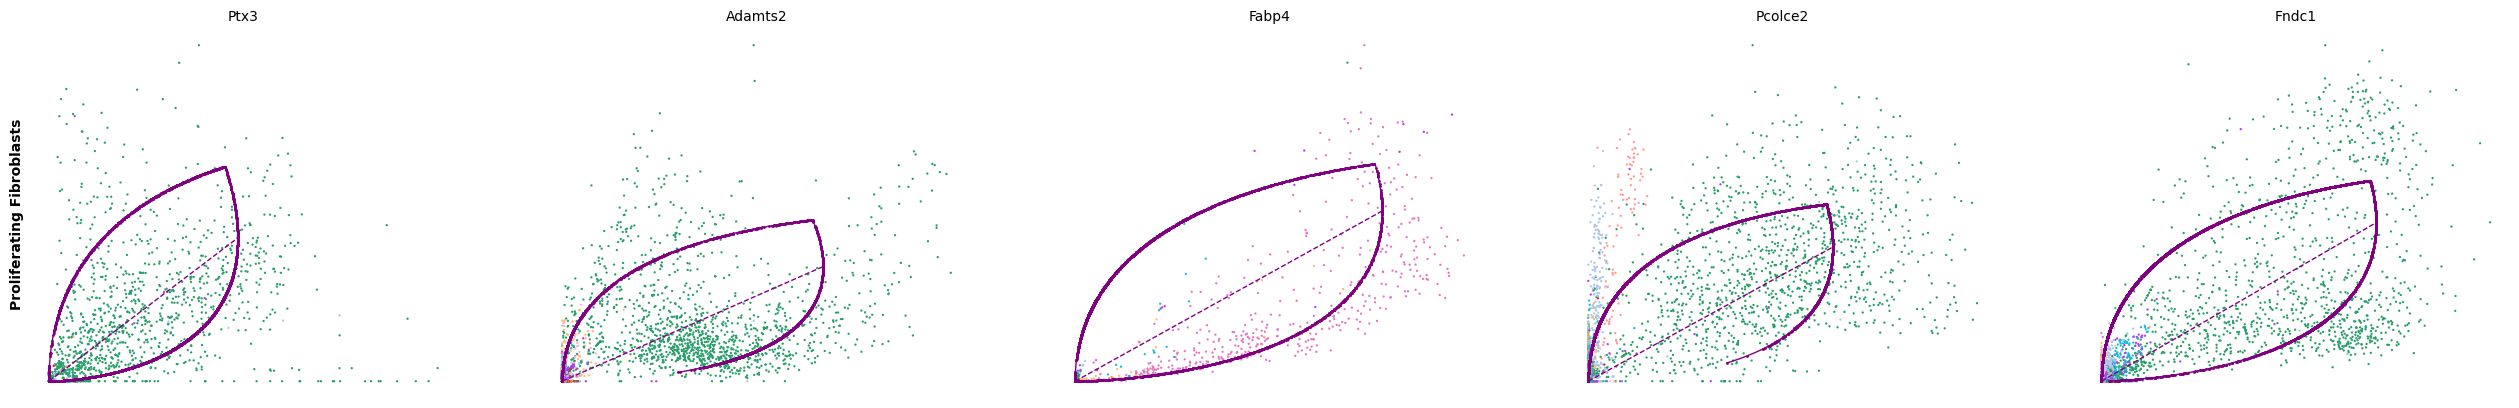

In [69]:
for cluster in ['IFE Keratinocytes', 'Fibroblasts', 'Proliferating immune cells', 'Proliferating Fibroblasts']:
    scv.pl.scatter(adata_hvg, df[cluster][:5], ylabel=cluster, frameon=False, color='celltype')

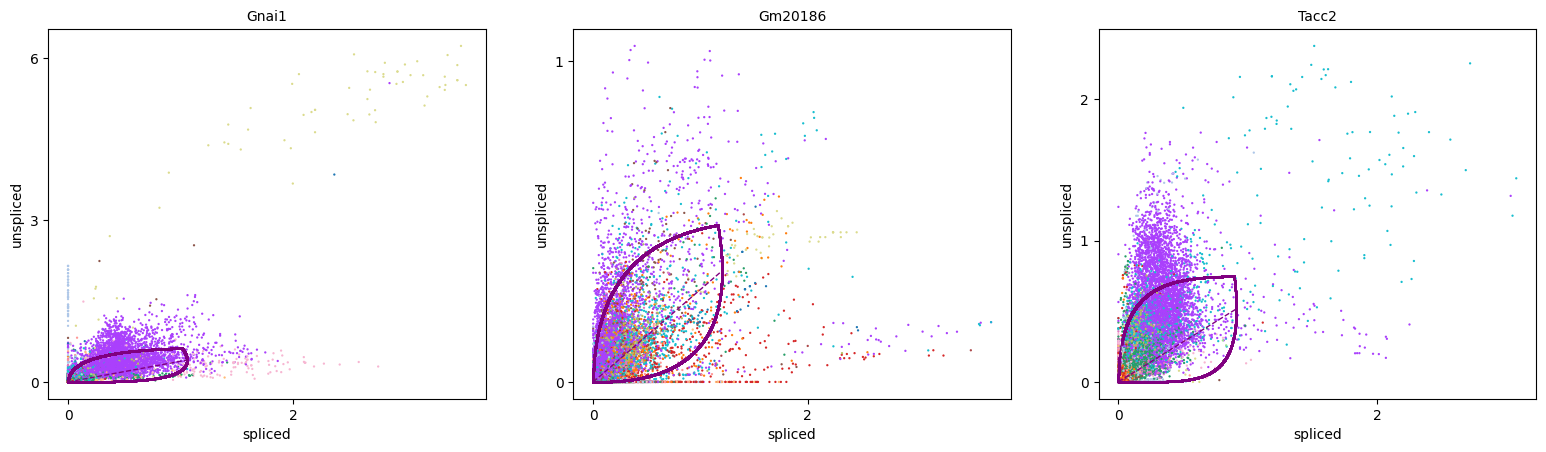

In [35]:
scv.pl.scatter(adata_hvg, color='celltype', basis=adata_hvg.uns["rank_velocity_genes"]["names"]["IFE Keratinocytes"][:3])

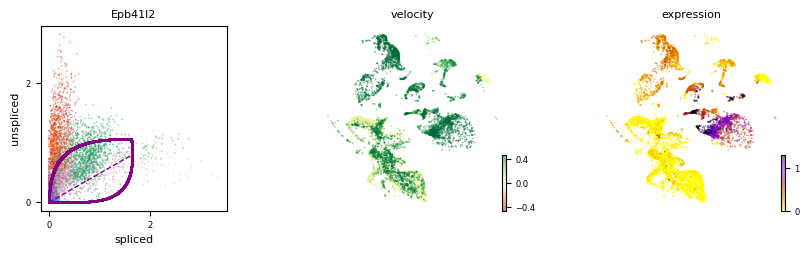

In [70]:
scv.pl.velocity(adata_hvg, ['Epb41l2'], color='celltype')

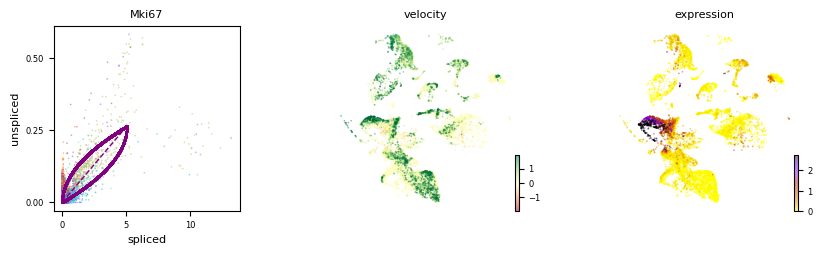

In [77]:
scv.pl.velocity(adata_hvg, ['Mki67'], color='celltype') # Proliferating Keratinocytes

computing terminal states
    identified 8 regions of root cells and 4 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


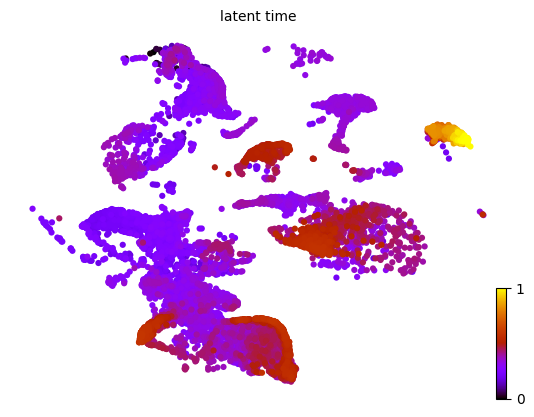

In [ ]:
scv.tl.latent_time(adata_hvg)
scv.pl.scatter(adata_hvg, color='latent_time', color_map='gnuplot', size=80)


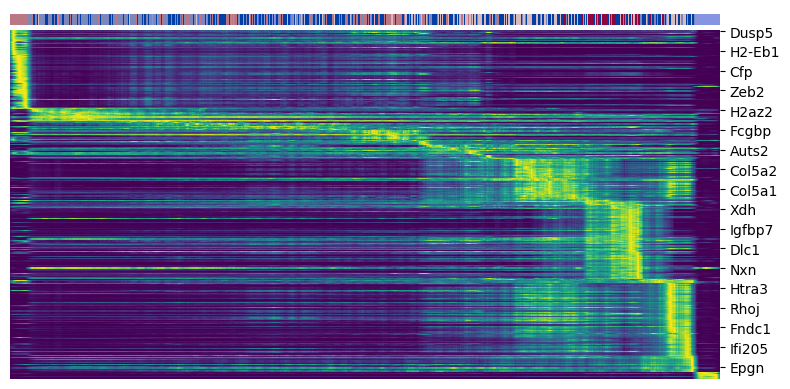

In [58]:
top_genes = adata_hvg.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata_hvg, var_names=top_genes, sortby='latent_time', col_color='metaclusters', n_convolve=100)


In [72]:
top_genes

Index(['Fstl1', 'Fbn1', 'Pecam1', 'H2-Eb1', 'Zbtb20', 'Hs3st1', 'Plet1',
       'Cytip', 'Jam2', 'Celf2',
       ...
       'Kcnip4', 'Krt73', 'A330069K06Rik', 'Grm7', 'Crnn', 'Oca2', 'Krt26',
       'Krt72', 'Dsg4', 'Krtap15'],
      dtype='object', length=2000)

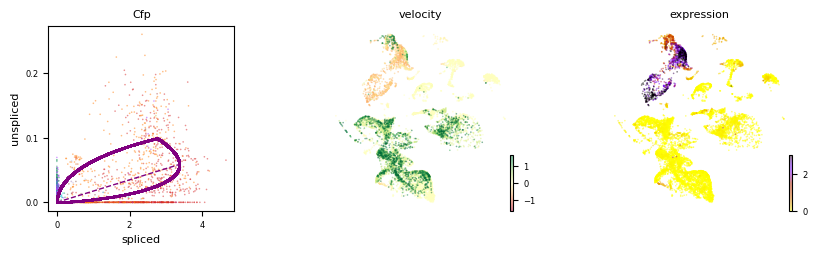

In [75]:
scv.pl.velocity(adata_hvg, ['Cfp'], color='celltype')

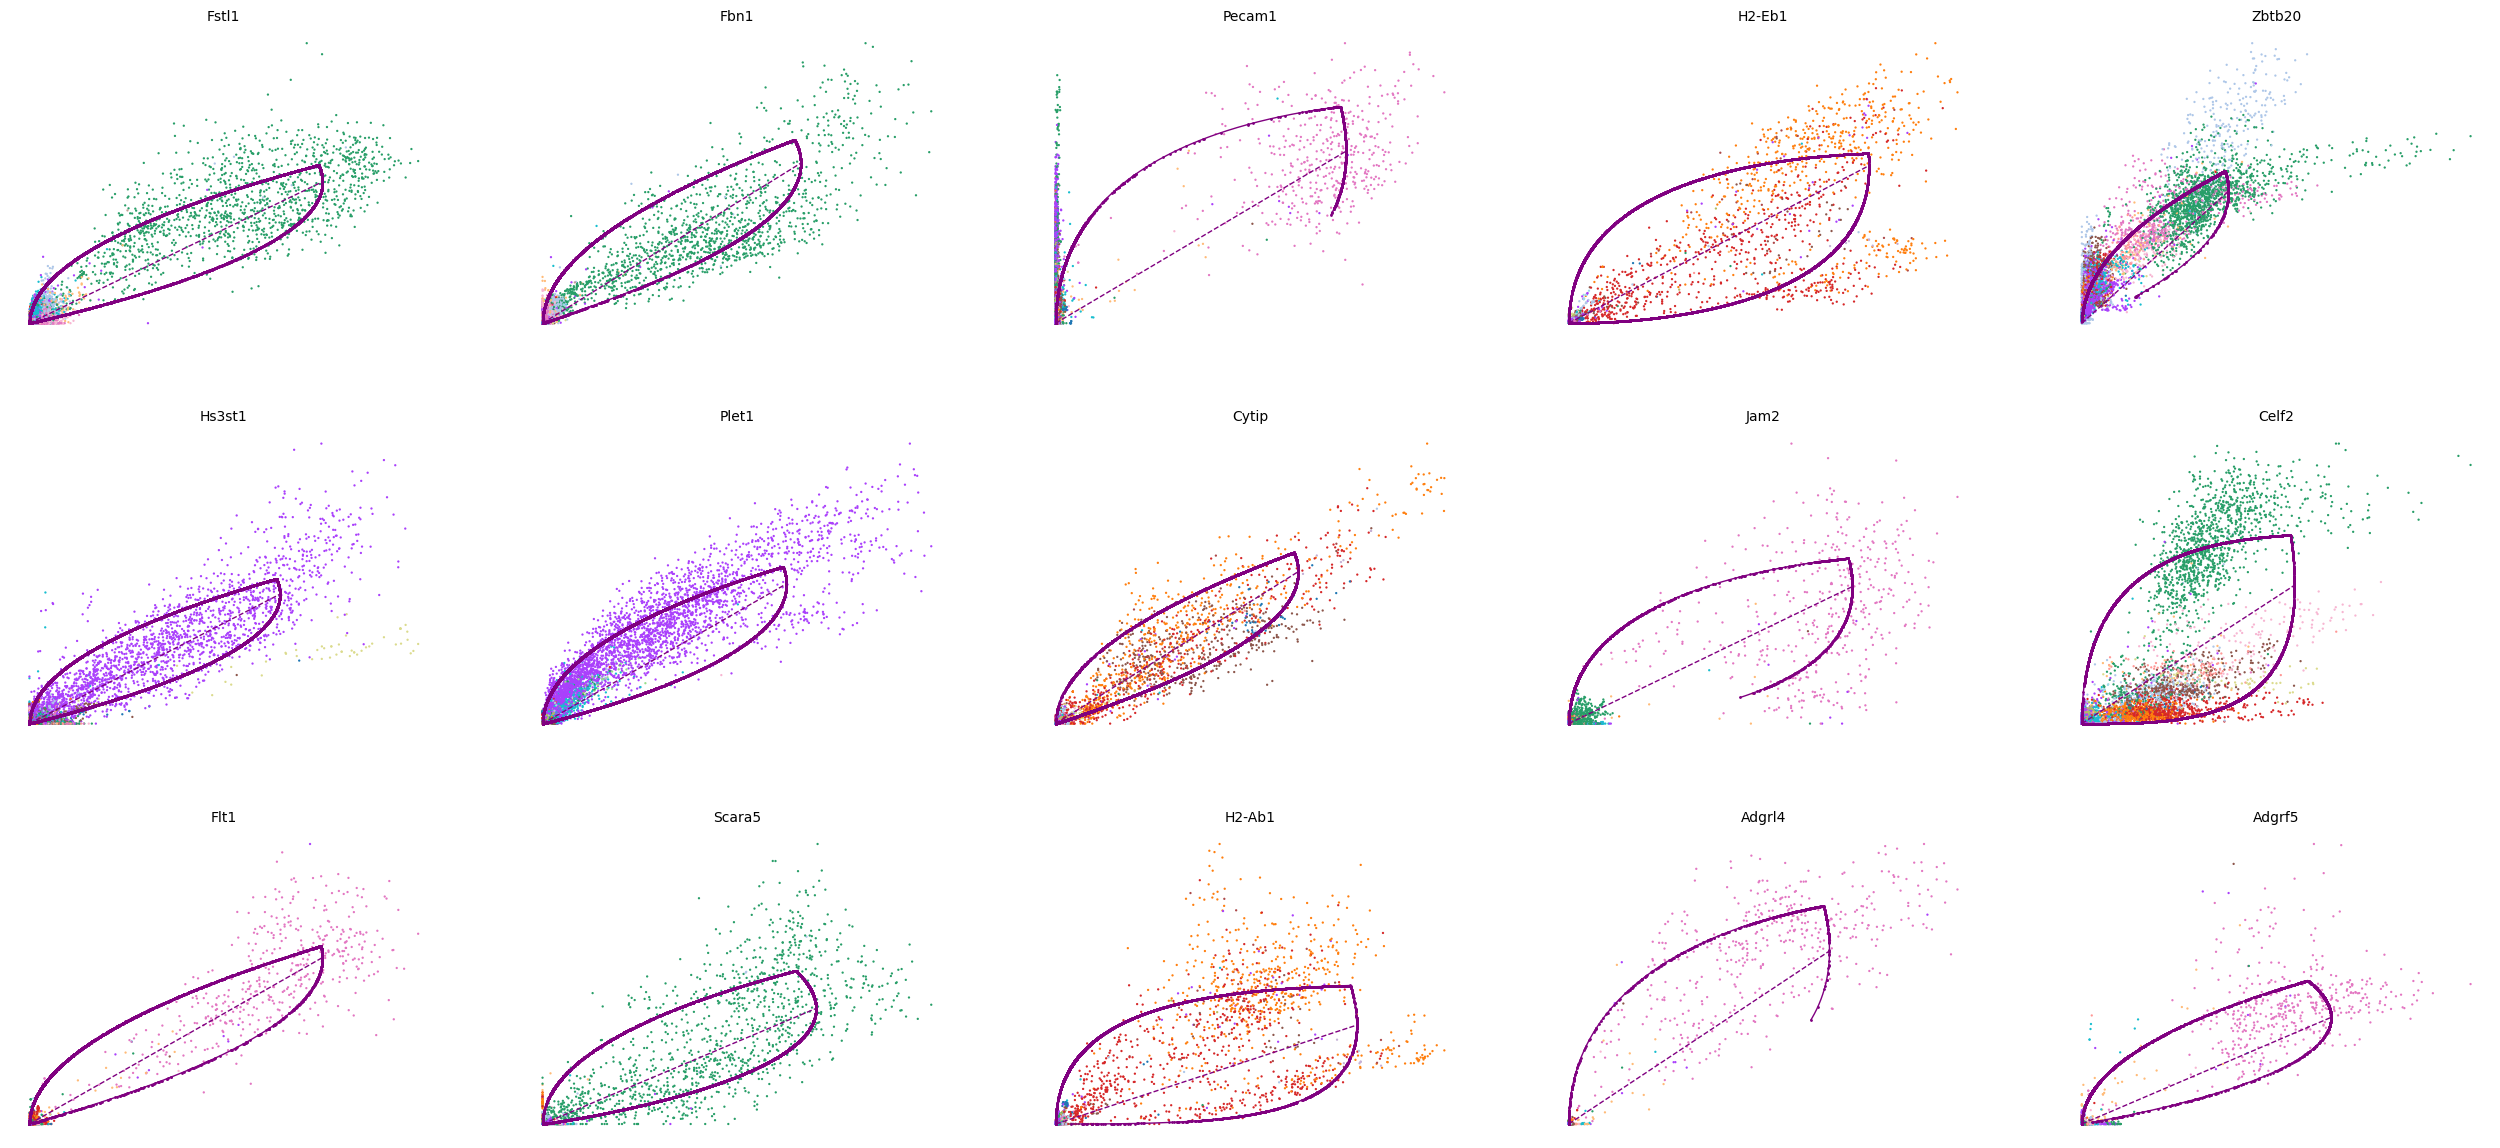

In [60]:
top_genes = adata_hvg.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata_hvg, basis=top_genes[:15], ncols=5, frameon=False, color='celltype',)

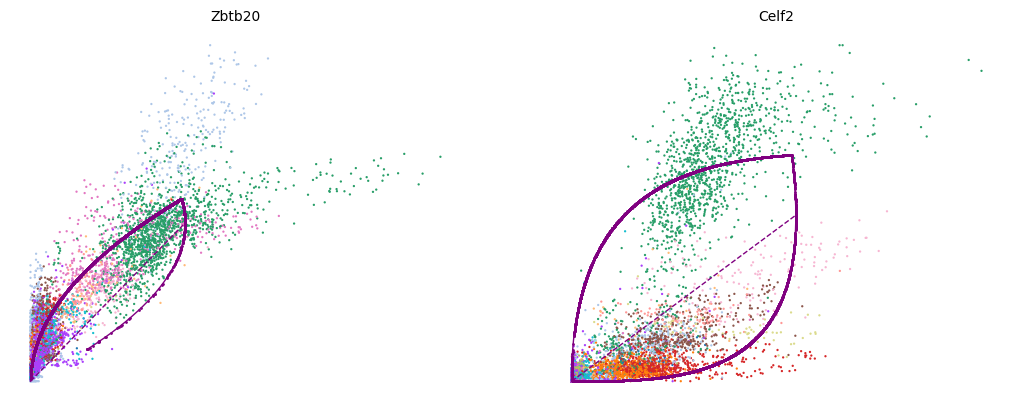

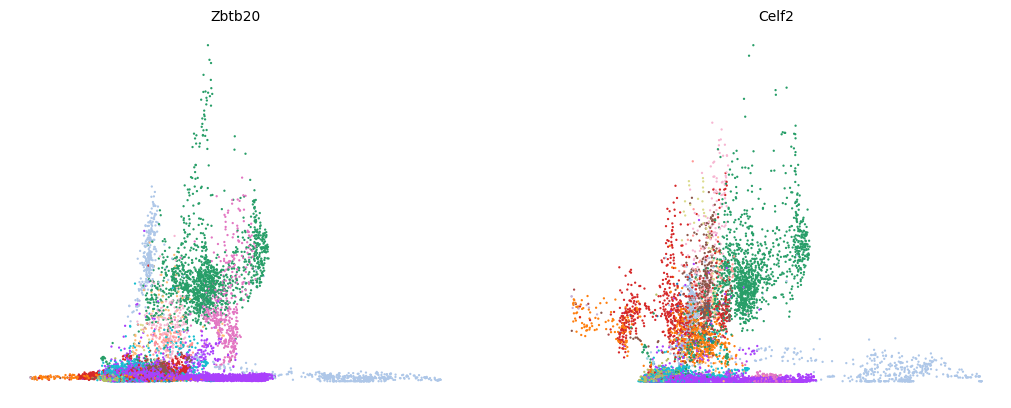

In [66]:
var_names = ['Zbtb20', 'Celf2']
scv.pl.scatter(adata_hvg, var_names, frameon=False, color='celltype',)
scv.pl.scatter(adata_hvg, x='latent_time', y=var_names, frameon=False, color='celltype',)